<a href="https://colab.research.google.com/github/riobastian09/DL-with-U-NET-for-Segmentation/blob/main/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [4]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=db47ee9be8ec68a64178d43140e289cd8de777e84f8fb866e4184c30bef9b924
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=5767ed7458649f38d63966aebe9276196cf1afb60f70139edb9dbc666733e692
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [5]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 20.75 MiB/s, done.
Resolving deltas: 100% (3/3), done.


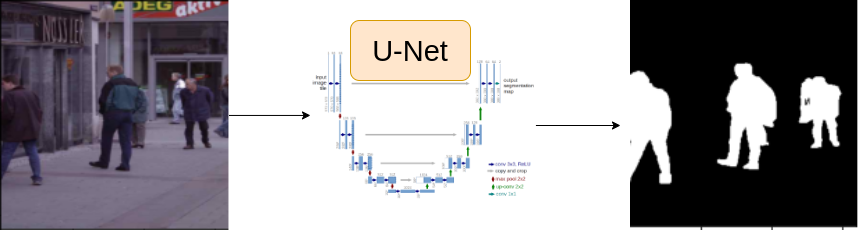

# Some Common Imports

In [6]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [7]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [8]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

# Tunning
EPOHCS = 25
LR = 0.003  #Learning Rate
IMG_SIZE = 320
BATCH_SIZE = 16

#Encoder memiliki banyak variant yang dapat dilihat pada link berikut : https://smp.readthedocs.io/en/latest/encoders.html
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [9]:
#Read and Show Dataset Location
df = pd.read_csv(CSV_FILE)
df.head() 

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [10]:
#Read Images from Location of Dataset 
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #Konversi Warna dari yang semula BGR KE RGB

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0 #Mengubah gambar masked tersebut ke grayscale

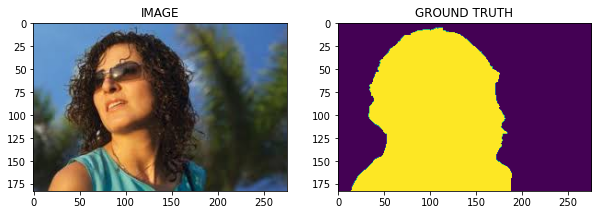

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)
# ax2.imshow(mask,cmap = 'gray') #Ori

In [12]:
#Splitting Dataset | Membagi dataset ke dataset Train dan Test
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [13]:
import albumentations as A

In [14]:
#Membuat fungsi anotasi gambar train
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),        #Membalik gambar secara horizontal sebesar 50%
      A.VerticalFlip(p = 0.5)         #Membalik gambar secara vertikal sebesar 50%
      #parameter "p" (float): probabilitas penerapan transformasi. Bawaan: 0,5\
      #Jadi augmentasi ini tidak selalu terjadi, dikarewnakan data yang diubah akan diprobabilitaskan dari 50% kemungkinan saja
  ],is_check_shapes = 0)

#Membuat fungsi anotasi gambar validasi
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),

  ],is_check_shapes = 0)

#NOTE : Program Ori tidak menggunakan "is_check_shapes = 0". Disini saya menggunakan ini dikarenakan program saya mengalami 
# error pada beberapa dataset dikarenakan data tersebut merupakan data yang corrput dan tidak sama dimensi dari data gambar
# ori dan data gambar masked

# Task 4 : Create Custom Dataset 

In [15]:
from torch.utils.data import Dataset

In [16]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations
  
  #Mengembalikan nilai dari panjang dataset
  def __len__(self):
    return len(self.df)

  #Mengembalikan gambar ori dan gambar masked dari indeks yang telah diberikan dari proses sebelumnya
  def __getitem__(self, idx):
    
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)    #dari (h,w)
    mask = np.expand_dims(mask, axis = -1)                #ke (h,w,c)

    if self.augmentations :   #Mengaplikasikan teknik augmentasi, jika parameter augmentasi bernilai True
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    
    #Switch channel
    #(h,w,c) -> (c,h,w)
    # h = index ke 0
    # w = index ke 1
    # c = index ke 2

    image = np.transpose(image, (2,0,1)).astype(np.float32) #Gambar Ori
    mask = np.transpose(mask, (2,0,1)).astype(np.float32) #Gambar Masked
    # c = index ke 0
    # h = index ke 1
    # w = index ke 2

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)
    #Tujuan dari dibagi 255.0 ialah untuk menetapkan range gambar menjadi 0 hingga 1 (integer)

    return image, mask

In [17]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [18]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


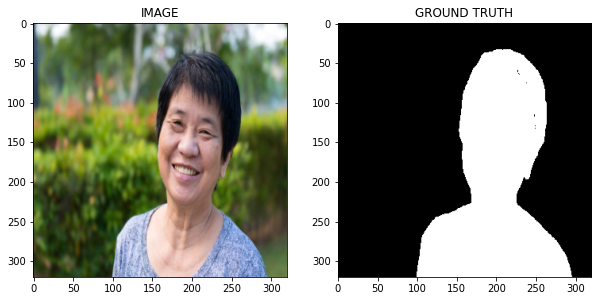

In [19]:
idx = 3     #index

image, mask = trainset[idx]
helper.show_image(image, mask)

#Efek dari augmentasi terkadang membuat gambar membali secara vertkal dan horizomal
#Kenapa terkadang? Karena probabilitas augmentasi itu akan terjadi sebesar 50% saja

# Task 5 : Load dataset into batches

In [20]:
from torch.utils.data import DataLoader

In [21]:
#shuffle bertujuan untuk mengacak setiap epohcs yang berjalan
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle = False)
trainloader, validloader

(<torch.utils.data.dataloader.DataLoader at 0x7fbacaf69c40>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbacaf69c70>)

In [22]:
broken_idx = []

for idx in range(len(trainset)):
  try:
    image, mask = trainset[idx]
    print(image.shape)
    print(mask.shape)
  except ValueError:
    broken_idx.append(idx)
    pass
print(broken_idx)  

torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([3, 320, 320])
torch.Size([1, 320, 320])
torch.Size([

In [23]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")
# Jika Batch Size 16, maka total data train yang ditetapkan, yakni sebesar 232 akan dibagi menjadi 16. Begitupun untuk data validasi.
# Sehingga :
# Train = 232/16 = 14,5 -> 15
# Valid = 58/16 = 3,625 -> 4

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [24]:
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([3, 320, 320])
One batch mask shape : torch.Size([1, 320, 320])


In [25]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [26]:
from torch import nn
import segmentation_models_pytorch as smp # Segmentrasi Model
from segmentation_models_pytorch.losses import DiceLoss  # Loss Function

In [27]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  
  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:   #Calcuilate Loss
      loss1 = DiceLoss(mode = 'binary')(logits, masks)  #DiceLoss from Pytorch
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)     #Binary Cross Entrophy (BCE) Loss
      return logits, loss1+loss2
    return logits

In [29]:
model = SegmentationModel()
model.to(DEVICE);
# Program baris ke 2, dikasih tanda ";" untuk menghapus output yang diberikan

# Task 7 : Create Train and Validation Function 

In [30]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  #tqdm digunakan untuk melakukan track batch yang berjalan
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [31]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    #tqdm digunakan untuk melakukan track batch yang berjalan
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [33]:
best_valid_loss = np.Inf

for i in range(EPOHCS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:      # Menyimpan model terbaik
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model terbaik baru saja disimpan")
    best_valid_loss = valid_loss
  
  print(f"Epohcs : {i+1} | Train_Loss : {train_loss} | Valid_loss : {valid_loss} |")

100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Model terbaik baru saja disimpan
Epohcs : 1 | Train_Loss : 0.7424639026323955 | Valid_loss : 0.6445043906569481 |


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Model terbaik baru saja disimpan
Epohcs : 2 | Train_Loss : 0.3492278973261515 | Valid_loss : 0.6398262083530426 |


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


Model terbaik baru saja disimpan
Epohcs : 3 | Train_Loss : 0.318224173784256 | Valid_loss : 0.26519715040922165 |


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epohcs : 4 | Train_Loss : 0.24500706493854524 | Valid_loss : 0.2763463333249092 |


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Model terbaik baru saja disimpan
Epohcs : 5 | Train_Loss : 0.29214803377787274 | Valid_loss : 0.2508799582719803 |


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


Model terbaik baru saja disimpan
Epohcs : 6 | Train_Loss : 0.21327995856602985 | Valid_loss : 0.21011820435523987 |


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epohcs : 7 | Train_Loss : 0.18369642595450084 | Valid_loss : 0.2537653110921383 |


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epohcs : 8 | Train_Loss : 0.19376593629519145 | Valid_loss : 0.24743863195180893 |


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Model terbaik baru saja disimpan
Epohcs : 9 | Train_Loss : 0.17997237890958787 | Valid_loss : 0.20319359377026558 |


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epohcs : 10 | Train_Loss : 0.1683509384592374 | Valid_loss : 0.24057399109005928 |


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epohcs : 11 | Train_Loss : 0.18352078596750895 | Valid_loss : 0.318109143525362 |


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epohcs : 12 | Train_Loss : 0.15532910426457722 | Valid_loss : 0.22832145914435387 |


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epohcs : 13 | Train_Loss : 0.15461817036072414 | Valid_loss : 0.2869812473654747 |


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


Model terbaik baru saja disimpan
Epohcs : 14 | Train_Loss : 0.1585101549824079 | Valid_loss : 0.19176465272903442 |


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epohcs : 15 | Train_Loss : 0.1803689236442248 | Valid_loss : 0.22222376242280006 |


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epohcs : 16 | Train_Loss : 0.1526749849319458 | Valid_loss : 0.2587297409772873 |


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epohcs : 17 | Train_Loss : 0.1493032842874527 | Valid_loss : 0.24755947664380074 |


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epohcs : 18 | Train_Loss : 0.14008469382921854 | Valid_loss : 0.23523679375648499 |


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epohcs : 19 | Train_Loss : 0.1300674964984258 | Valid_loss : 0.2230505831539631 |


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Model terbaik baru saja disimpan
Epohcs : 20 | Train_Loss : 0.10491583148638407 | Valid_loss : 0.1613914594054222 |


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epohcs : 21 | Train_Loss : 0.10643830498059591 | Valid_loss : 0.16916072741150856 |


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Epohcs : 22 | Train_Loss : 0.09930965602397919 | Valid_loss : 0.17848043516278267 |


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epohcs : 23 | Train_Loss : 0.10303241113821665 | Valid_loss : 0.21145443245768547 |


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epohcs : 24 | Train_Loss : 0.10664504716793696 | Valid_loss : 0.17780140414834023 |


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

Epohcs : 25 | Train_Loss : 0.11507204125324885 | Valid_loss : 0.255101028829813 |


# Task 9 : Inference

In [36]:
idx = 2

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #Proses Unsqueeze : (C, H, W) _> (1, C, H, W) | Menambahkan dimensi ekstra
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

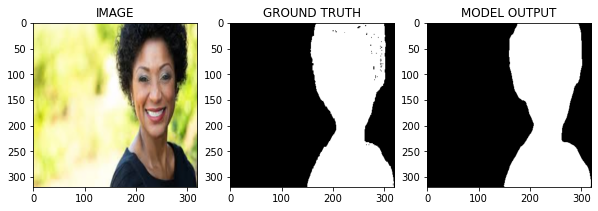

In [37]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya